# General data reader for AQUA 
## Spatial (weighted field) averaging

When we instantiate the reader object, grid areas for the source files are computed if not already available. If regridding is requested, these are computed also for the destination grid. After this we can use the computed grid_areas to do for example spatial averaging using the `fldmean` method. 

In [1]:
from aqua import Reader

### Example 1: AVISO


We read some AVISO data

In [2]:
from aqua import Reader
reader = Reader(model="AVISO", exp="ssh-L4", source="daily")
data = reader.retrieve()
data

2024-02-22 18:41:04 :: Reader :: WARNING  -> The requested default fixer name AVISO-default does not exist in fixes files
2024-02-22 18:41:04 :: Reader :: WARNING  -> No fixes available for model AVISO, experiment ssh-L4, source daily
2024-02-22 18:41:12 :: Reader :: ERROR    -> Variable crs has no units!
2024-02-22 18:41:12 :: Reader :: ERROR    -> Variable flag_ice has no units!


<xarray.Dataset> Size: 893GB
Dimensions:         (time: 10766, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 8B 0 1
  * time            (time) datetime64[ns] 86kB 1993-01-01 ... 2022-06-23
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs             (time) float64 86kB dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 86kB dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

The first time the reader is instantiated, if not already available, cell area files are computed and stored in the directory specified in `config/regrid.yaml`. Notice that this operation needs to be performed once for each data source. 

The grid cell areas are available and stored in the reader. The following grid cell areas are available:
- `reader.src_grid_area`: the grid cell areas of the original grid
- `reader.dst_grid_area`: the grid cell areas of the destination grid (if regridding is used)
- `reader.grid_area`    : the source or destination grid cell areas, depending if regridding has already been performed or not


Let's pick only part of the data

In [3]:
data

<xarray.Dataset> Size: 893GB
Dimensions:         (time: 10766, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
  * latitude        (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 8B 0 1
  * time            (time) datetime64[ns] 86kB 1993-01-01 ... 2022-06-23
Data variables: (12/14)
    adt             (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    crs             (time) float64 86kB dask.array<chunksize=(1,), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...              ...
    sla             (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    tpa_correction  (time) float64 86kB dask.array<chunksize=(1,), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 89GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [4]:
flag_ice=data['flag_ice'].isel(time=range(0,96))

We can now compute a field average and plot the resulting timeseries

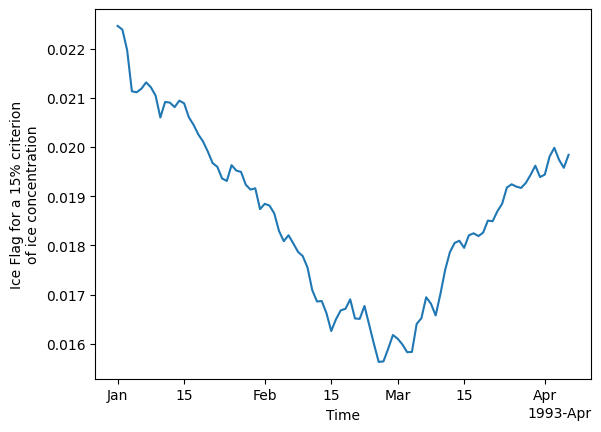

In [5]:
global_mean = reader.fldmean(flag_ice)
global_mean.plot()

### Example 2: EN4

Let's start without interpolation

In [6]:
reader = Reader(model="EN4", exp="en4", source="monthly")
data = reader.retrieve()

2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable time_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lon_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lat_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lev_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lon_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lat_bnds has no units!
2024-02-22 18:41:15 :: Reader :: ERROR    -> Variable lev_bnds has no units!


Let's demonstrate how we can compute a global (field) averages. Instatiating the reader has also computed grid areas (stored internally in the reader object). Since no regridding has been requested the reader assumes that we wish to work with the original data. Let's extract a short timeseries of fields. The first frame for this data source is not valid.

In [7]:
data

<xarray.Dataset> Size: 38GB
Dimensions:             (time: 876, bnds: 2, lon: 360, lat: 180, lev: 42)
Coordinates:
  * time                (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 202...
  * lon                 (lon) float64 3kB 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0
  * lat                 (lat) float64 1kB -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * lev                 (lev) float32 168B 5.022 15.08 ... 5.051e+03 5.35e+03
    idx_lev             (lev) int64 336B 0 1 2 3 4 5 6 ... 35 36 37 38 39 40 41
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 14kB dask.array<chunksize=(12, 2), meta=np.ndarray>
    lon_bnds            (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds            (lat, bnds) float64 3kB dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float32 336B dask.array<chunksize=(42, 2), meta=np.ndarray>
    avg_so              (time, lev, lat, lon) float32 10GB dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    so_uncertainty      (time, lev, lat, lon) float32 10GB dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    avg_thetao          (time, lev, lat, lon) float32 10GB dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    thetao_uncertainty  (time, lev, lat, lon) float32 10GB dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
Attributes: (12/25)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    Conventions:            CF-1.0
    institution:            UK Met Office
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    ...                     ...
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...
    history:                Thu Jun 29 09:47:09 2023: cdo mergetime so_195001...
    NCO:                    netCDF Operators version 4.9.2 (Homepage = http:/...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

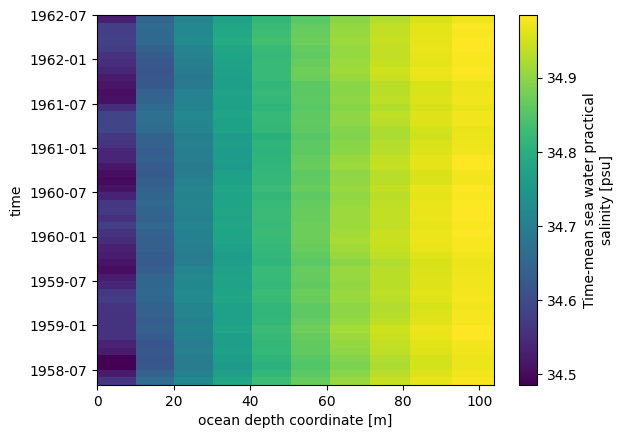

In [9]:
so = data.avg_so.isel(time=slice(100,150)).isel(lev=slice(0,10))
global_mean_3d = reader.fldmean(so)
global_mean_3d.plot()

The timeseries for the `depth=0`, which is equal to 5.022 m, is:

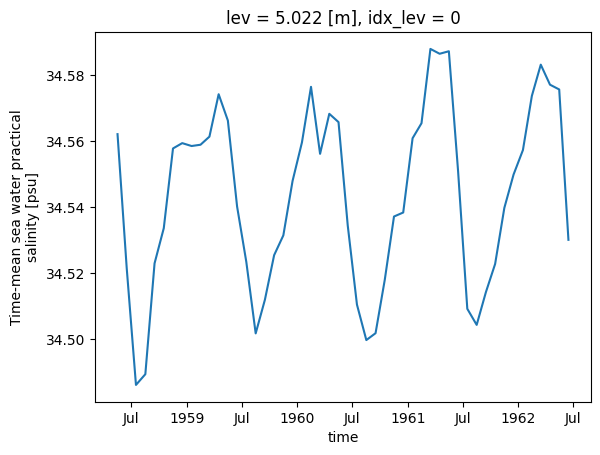

In [10]:
global_mean_2d = reader.fldmean(so.isel(lev=0))
global_mean_2d.plot()

Now let's ask for regridding instead.

Instantiate a reader for EN4 data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [11]:
reader = Reader(model="EN4", exp="en4", source="monthly", regrid="r100", fix=False)

Load the actual data. By default these data have not been regridded yet. 

In [10]:
data = reader.retrieve()

Now we actually regrid part of the data

In [11]:
data.so

<xarray.DataArray 'so' (time: 876, lev: 42, lat: 180, lon: 360)>
dask.array<open_dataset-so, shape=(876, 42, 180, 360), dtype=float32, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lev      (lev) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
    idx_lev  (lev) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40 41
Attributes:
    standard_name:  salinity
    long_name:      Salinity
    units:          0.001

In [12]:
data_so = data.so.isel(time=slice(100,150)).isel(lev=0)
data_r100 = reader.regrid(data_so)

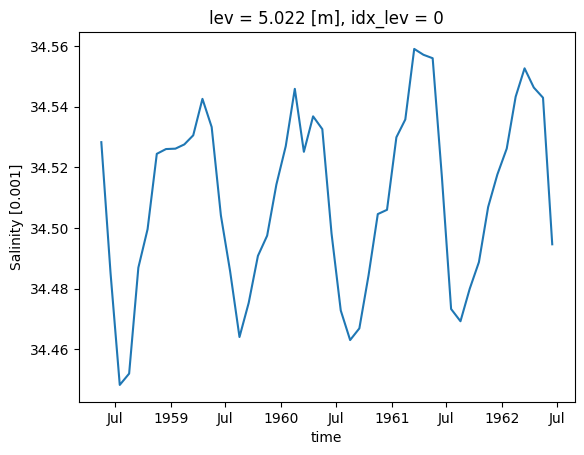

In [13]:
global_mean_r100 = reader.fldmean(data_r100)
global_mean_r100.plot()

The same average could have been performed directly using the cell areas:

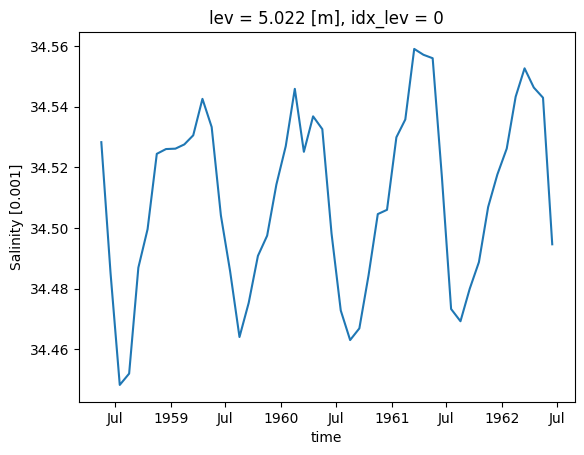

In [14]:
data_r100.weighted(weights=reader.dst_grid_area).mean(dim=reader.dst_space_coord).plot()

How much do the global averages done on the interpolated and original fields differ ?

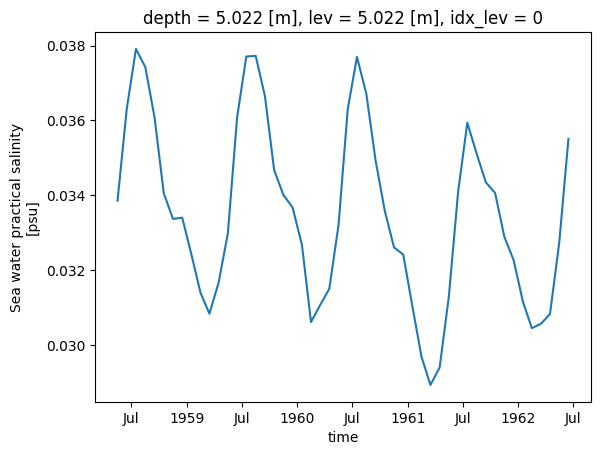

In [15]:
(global_mean_2d - global_mean_r100).plot()

### Example 5: CERES data - further interpolation

In [16]:
from aqua import Reader
reader = Reader(model="CERES", exp="ebaf-sfc41", source="monthly", regrid="r250")

Retrieving and plotting it

In [17]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:                (time: 265, lon: 360, lat: 180)
Coordinates:
  * time                   (time) datetime64[ns] 2000-03-15 ... 2022-03-15
  * lon                    (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Data variables: (12/32)
    toa_sw_clr_t_mon       (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_lw_clr_t_mon       (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_net_clr_t_mon      (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_sw_mon         (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_lw_mon         (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_cre_net_mon        (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    ...                     ...
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_sw_mon     (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_lw_mon     (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    sfc_cre_net_tot_mon    (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    msnlwrf                (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    msnswrf                (time, lat, lon) float32 dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    institution:  NASA Langley Research Center
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1
    history:      Mon Jan 16 07:55:23 2023: cdo -mergetime CERES_EBAF_Ed4.1_S...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

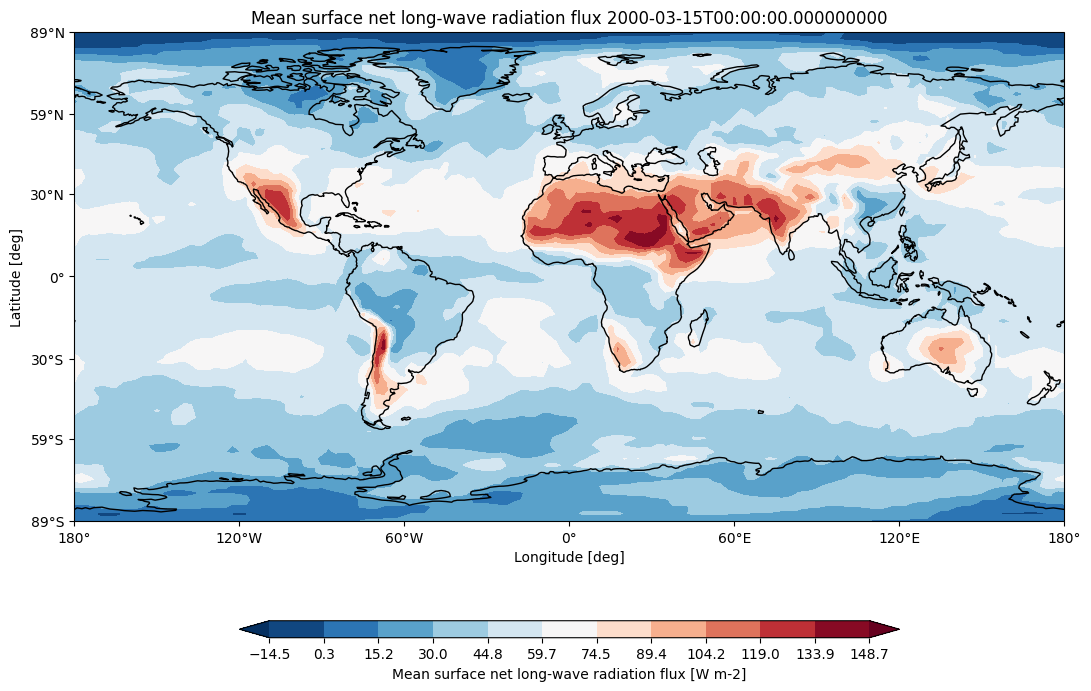

In [18]:
data.msnlwrf.isel(time=0).aqua.regrid().aqua.plot_single_map()

A timeseries directly from the original data:

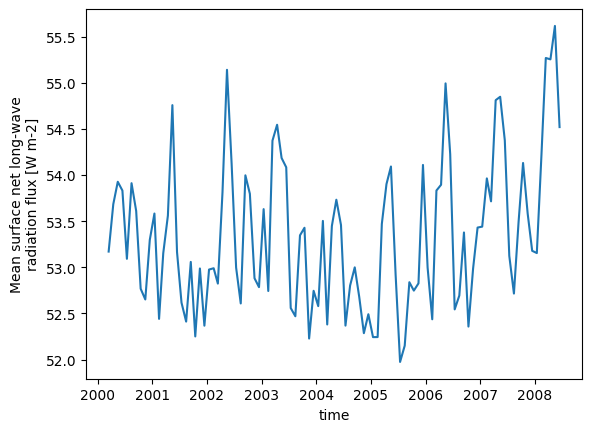

In [19]:
msnlwrf_mon = data['msnlwrf'].isel(time=range(0,100))
msnlwrf_mon.aqua.fldmean().plot()